In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [4]:
data = pd.read_csv('dataset/eth.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,31.Oct.17,307.38,310.55,305.88,305.88,"369,583,008.00","29,331,517,440.00"
1,1.Nov.17,305.76,306.40,290.58,291.69,"553,864,000.00","29,183,592,448.00"
2,2.Nov.17,290.73,293.91,281.17,287.43,"904,900,992.00","27,754,237,952.00"
3,3.Nov.17,288.50,308.31,287.69,305.71,"646,339,968.00","27,547,410,432.00"
4,4.Nov.17,305.48,305.48,295.80,300.47,"416,479,008.00","29,175,347,200.00"


In [9]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2
print(mid_prices)

[ 308.215  298.49   287.54   298.     300.64   298.245  299.57   297.805
  305.9    318.255  309.63   308.82   308.83   317.72   328.47   335.36
  329.885  331.24   338.655  358.015  362.715  361.58   370.785  400.82
  441.865  473.12   462.165  480.94   474.415  473.69   433.37   450.46
  466.445  467.33   464.045  465.61   441.46   427.905  444.215  480.2
  451.15   478.035  580.905  672.895  709.055  659.095  699.59   716.035
  746.58   833.64   800.53   836.615  685.72   721.815  668.345  740.695
  773.86   763.83   732.255  749.865  719.525  735.235  762.265  843.59
  921.46   995.585 1015.86  1027.665 1098.09  1141.49  1233.235 1321.99
 1236.235 1208.065 1351.675 1343.385 1340.595 1084.085  935.575 1034.035
 1048.465 1106.03  1088.59  1009.92   971.885 1014.125 1069.7   1038.69
 1082.05  1184.775 1212.89  1121.8   1081.58  1073.085  896.875  919.815
  887.045  750.625  685.43   787.315  800.465  836.415  871.49   823.755
  846.725  849.775  885.355  931.53   933.93   958.67   949

In [8]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])
print(result)

[array([308.215, 298.49 , 287.54 , 298.   , 300.64 , 298.245, 299.57 ,
       297.805, 305.9  , 318.255, 309.63 , 308.82 , 308.83 , 317.72 ,
       328.47 , 335.36 , 329.885, 331.24 , 338.655, 358.015, 362.715,
       361.58 , 370.785, 400.82 , 441.865, 473.12 , 462.165, 480.94 ,
       474.415, 473.69 , 433.37 , 450.46 , 466.445, 467.33 , 464.045,
       465.61 , 441.46 , 427.905, 444.215, 480.2  , 451.15 , 478.035,
       580.905, 672.895, 709.055, 659.095, 699.59 , 716.035, 746.58 ,
       833.64 , 800.53 ]), array([298.49 , 287.54 , 298.   , 300.64 , 298.245, 299.57 , 297.805,
       305.9  , 318.255, 309.63 , 308.82 , 308.83 , 317.72 , 328.47 ,
       335.36 , 329.885, 331.24 , 338.655, 358.015, 362.715, 361.58 ,
       370.785, 400.82 , 441.865, 473.12 , 462.165, 480.94 , 474.415,
       473.69 , 433.37 , 450.46 , 466.445, 467.33 , 464.045, 465.61 ,
       441.46 , 427.905, 444.215, 480.2  , 451.15 , 478.035, 580.905,
       672.895, 709.055, 659.095, 699.59 , 716.035, 746.58 , 8

In [7]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        print(window)
    return np.array(normalized_data)

result = normalize_windows(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

[308.215 298.49  287.54  298.    300.64  298.245 299.57  297.805 305.9
 318.255 309.63  308.82  308.83  317.72  328.47  335.36  329.885 331.24
 338.655 358.015 362.715 361.58  370.785 400.82  441.865 473.12  462.165
 480.94  474.415 473.69  433.37  450.46  466.445 467.33  464.045 465.61
 441.46  427.905 444.215 480.2   451.15  478.035 580.905 672.895 709.055
 659.095 699.59  716.035 746.58  833.64  800.53 ]
[298.49  287.54  298.    300.64  298.245 299.57  297.805 305.9   318.255
 309.63  308.82  308.83  317.72  328.47  335.36  329.885 331.24  338.655
 358.015 362.715 361.58  370.785 400.82  441.865 473.12  462.165 480.94
 474.415 473.69  433.37  450.46  466.445 467.33  464.045 465.61  441.46
 427.905 444.215 480.2   451.15  478.035 580.905 672.895 709.055 659.095
 699.59  716.035 746.58  833.64  800.53  836.615]
[287.54  298.    300.64  298.245 299.57  297.805 305.9   318.255 309.63
 308.82  308.83  317.72  328.47  335.36  329.885 331.24  338.655 358.015
 362.715 361.58  370.785 400.82

((283, 50, 1), (31, 50, 1))

In [6]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [7]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Epoch 1/20
 1/29 [>.............................] - ETA: 0s - loss: 0.2306WARNING:tensorflow:From C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - ETA: 0s - loss: 0.0795
Epoch 00001: val_loss improved from inf to 0.00117, saving model to ./models\2021_05_18_04_36_02_eth.h5
29/29 [==============================] - 1s 45ms/step - loss: 0.0795 - val_loss: 0.0012
Epoch 2/20
29/29 [==============================] - ETA: 0s - loss: 0.0474
Epoch 00002: val_loss improved from 0.00117 to 0.00085, saving model to ./models\2021_05_18_04_36_02_eth.h5
29/29 [==============================] - 0s 16ms/step - loss: 0.0474 - val_loss: 8.5395e-04
Epoch 3/20
28/29 [===========================>..] - ETA: 0s - loss: 0.0410
Epoch 00003: val_loss did not improve f

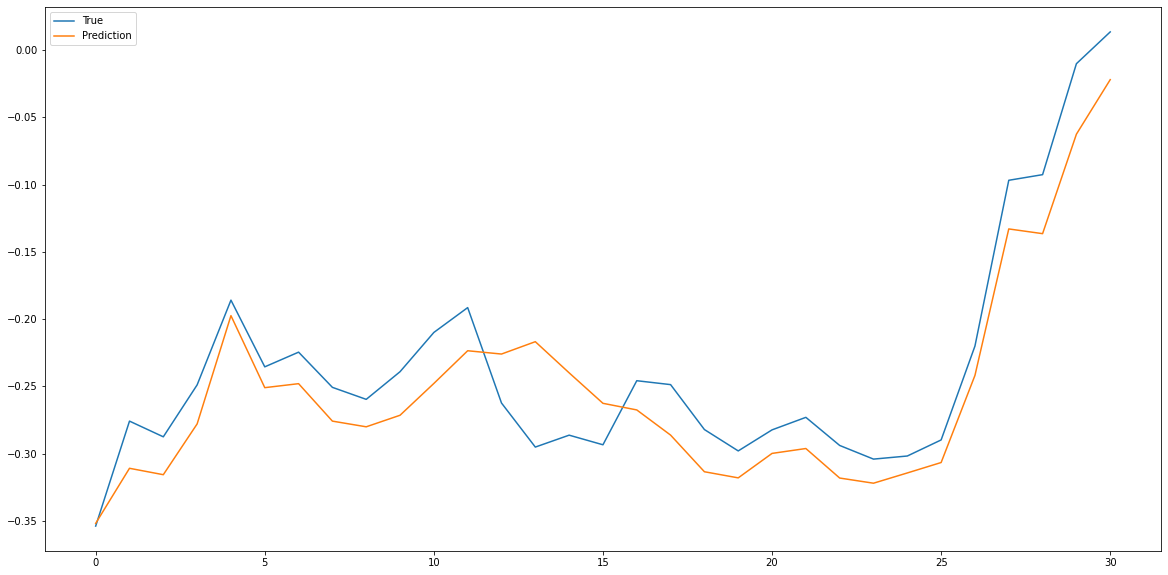

In [8]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()